In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os, sys

DATAPATH = '/content/drive/My Drive/Coursera/EDHEC/investment-portfolio/data'
print(f"DATAPATH:{DATAPATH} contents:{os.listdir(DATAPATH)}")

MODULEPATH = '/content/drive/My Drive/Coursera/EDHEC/investment-portfolio/nb'
print(f"MODULEPATH:{MODULEPATH} contents:{os.listdir(MODULEPATH)}")

sys.path.append(MODULEPATH)
print(f"sys.path:{sys.path}")

import numpy as np
import pandas as pd

import edhec_risk_kit_108_BBI as erk

DATAPATH:/content/drive/My Drive/Coursera/EDHEC/investment-portfolio/data contents:['sample_prices.csv', 'edhec-hedgefundindices.csv', 'ind30_m_vw_rets.csv', 'Portfolios_Formed_on_ME_monthly_EW.csv', 'ind30_m_ew_rets.csv']
MODULEPATH:/content/drive/My Drive/Coursera/EDHEC/investment-portfolio/nb contents:['lab_108.ipynb', 'lab_101.ipynb', 'lab_102.ipynb', 'lab_103.ipynb', 'hello.py', '__pycache__', 'edhec_risk_kit_104_BBI.py', 'lab_104.ipynb', 'edhec_risk_kit_105_BBI.py', 'lab_105.ipynb', 'edhec_risk_kit_106_BBI.py', 'lab_106.ipynb', 'module_1_quiz.ipynb', 'edhec_risk_kit_107_BBI.py', 'lab_107.ipynb', 'edhec_risk_kit_108_BBI.py']
sys.path:['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/Coursera/EDHEC/investment-portfolio/nb']


# The Efficient Frontier - Part II

Let's start by loading the returns and generating the expected returns vector and the covariance matrix

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#import edhec_risk_kit as erk

ind = erk.get_ind_returns(DATAPATH)
er = erk.annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


As a first exercise, let's assume we have some weights, and let's try and compute the returns and volatility of a portfolio, given a set of weights, returns, and a covariance matrix.

The returns are easy, so let's add this to our toolkit

```python

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

```

The volatility is just as easy in matrix form:

```python
def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5
```



In [0]:
l = ["Food", "Beer", "Smoke", "Coal"]

In [6]:
er[l]

Food     0.116799
Beer     0.141126
Smoke    0.107830
Coal     0.414689
dtype: float64

In [7]:
cov.loc[l,l]

,Food,Beer,Smoke,Coal
Food,0.002609,0.002379,0.002061,0.000027
Beer,0.002379,0.005264,0.001359,0.001728
Smoke,0.002061,0.001359,0.008349,-0.000733
Coal,0.000027,0.001728,-0.000733,0.018641


In [8]:
import pandas as pd
import numpy as np
ew = np.repeat(0.25, 4)
erk.portfolio_return(ew, er[l])

0.19511097196038385

In [9]:
erk.portfolio_vol(ew, cov.loc[l,l])

0.055059195776437045

# The 2-Asset Case

In the case of 2 assets, the problem is somewhat simplified, since the weight of the second asset is 1-the weight of the first asset.

Let's write a function that draws the efficient frontier for a simple 2 asset case.

Start by generating a sequence of weights in a list of tuples. Python makes it easy to generate a list by using something called a _list comprehension_ ... which you can think of as an efficient way to generate a list of values instead of writing a for loop.


In [0]:
import numpy as np

n_points = 20
weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]


In [11]:
type(weights)

list

In [12]:
len(weights)

20

In [13]:
weights[0]

array([0., 1.])

In [14]:
weights[4]

array([0.21052632, 0.78947368])

In [15]:
weights[19]

array([1., 0.])

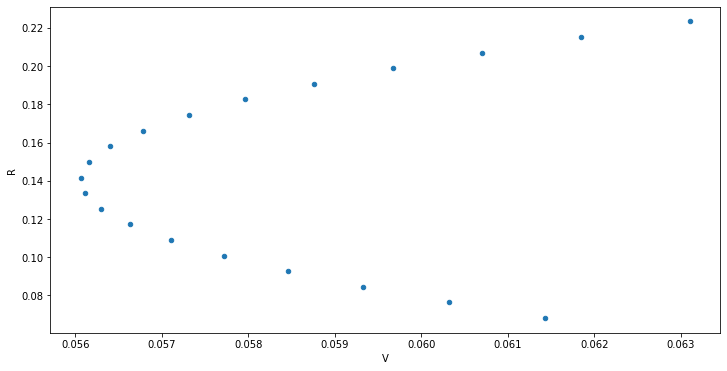

In [17]:
l = ["Games", "Fin"]
rets = [erk.portfolio_return(w, er[l]) for w in weights]
vols = [erk.portfolio_vol(w, cov.loc[l,l]) for w in weights]
ef = pd.DataFrame({"R": rets, "V": vols})
ef.plot.scatter(x="V", y="R", figsize = (12, 6))

We can create function that plots the frontier:

```python
def plot_ef2(n_points, er, cov):
    """
    Plots the 2-asset efficient frontier
    """
    if er.shape[0] != 2 or er.shape[0] != 2:
        raise ValueError("plot_ef2 can only plot 2-asset frontiers")
    weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style=".-")
```

A useful summary of the visualization features in pandas is [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)


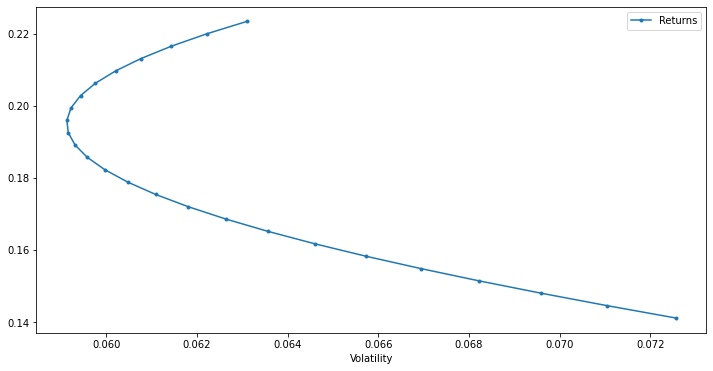

In [19]:
l = ["Fin", "Beer"]
erk.plot_ef2(25, er[l].values, cov.loc[l,l])